### 10-3 승차식 잔디깎이 기계의 판매. 승차식 잔디깎이를 제조하는 회사가 집중적인 판매 갬페인을 벌이기 위해 최고의 잠재 고객을 파악하고자 한다. 특히 제조업체는 소득(단위: 1000달러)과 주택 대지의 크기(단위: 1000제곱피트)를 기초로 하여 가구를 미래에 소유할 가능성이 있는 고객과 그렇지 않은 고객으로 분류하는 데 관심이 있다. 마케팅 전문가는 RidingMowers.csv파일에 들어 있는 랜덤 표본인 24가구를 살펴 보았다. 모든 데이터를 사용하여 2개 예측변수에 의한 소유 여부를 로지스틱 회귀로 적합했다.

a. 승차식 잔디깎이 기계를 소유한 가구의 비율은 얼마인가? 50%

In [ ]:
!pip install dmba
import pandas as pd

import dmba
data=dmba.load_data('ridingmowers.csv')
data.head()

,Income,Lot_Size,Ownership
0,60.0,18.4,Owner
1,85.5,16.8,Owner
2,64.8,21.6,Owner
3,61.5,20.8,Owner
4,87.0,23.6,Owner


In [ ]:
# Calculate the proportion of households that own a riding mower
ownership_counts = data['Ownership'].value_counts()
ownership_ratio = ownership_counts['Owner'] / len(data)

ownership_ratio


0.5

b. 다른 색상이나 기호를 이용하여, 승차식 잔디깎이 기계의 소유자와 비소유자를 구별하기 위해 소득과 주택 대지 크기에 대한 산점도를 그리시오. 이 산점도에서 소유자와 비소유자 중 어떤 클래스가 평균 소득보다 높은 소득을 가지는가?

소유자 클래스가 평균적으로 더 높은 소득을 가지고 있음

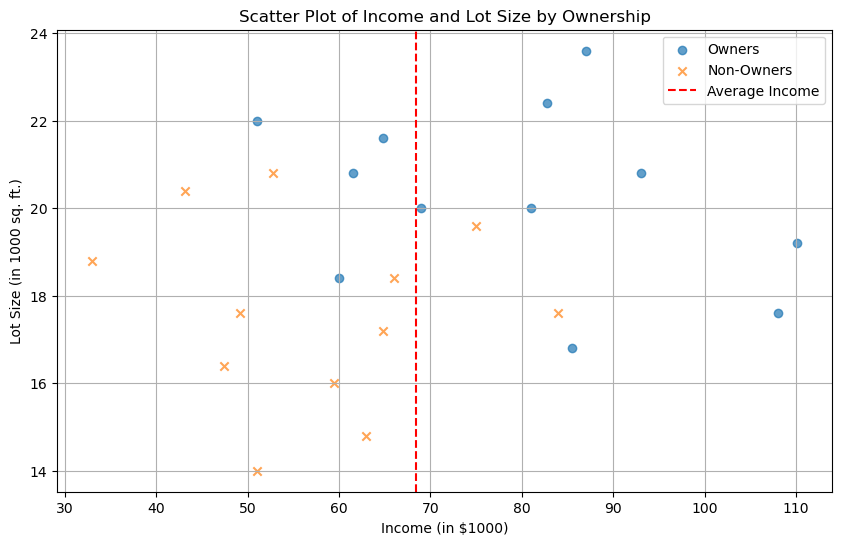

(79.47500000000001, 57.400000000000006)

In [3]:
import matplotlib.pyplot as plt

# Separate the data by ownership
owners = data[data['Ownership'] == 'Owner']
non_owners = data[data['Ownership'] != 'Owner']

# Calculate the average income
average_income = data['Income'].mean()

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(owners['Income'], owners['Lot_Size'], label='Owners', marker='o', alpha=0.7)
plt.scatter(non_owners['Income'], non_owners['Lot_Size'], label='Non-Owners', marker='x', alpha=0.7)

# Add a horizontal line for average income
plt.axvline(x=average_income, color='red', linestyle='--', label='Average Income')

# Add labels, legend, and title
plt.xlabel('Income (in $1000)')
plt.ylabel('Lot Size (in 1000 sq. ft.)')
plt.title('Scatter Plot of Income and Lot Size by Ownership')
plt.legend()
plt.grid(True)
plt.show()

# Determine the class with higher average income
average_income_owners = owners['Income'].mean()
average_income_non_owners = non_owners['Income'].mean()

average_income_owners, average_income_non_owners


c. 비소유자 중에서 정확하게 분류된 가구의 비율은 얼마인가?

50%

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Prepare the data for logistic regression
X = data[['Income', 'Lot_Size']]
y = (data['Ownership'] == 'Owner').astype(int)  # Encode 'Owner' as 1, others as 0

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate accuracy for non-owners in the test set
non_owners_test = y_test[y_test == 0]  # Filter non-owners
non_owners_pred = y_pred[non_owners_test.index]  # Predictions for non-owners
non_owners_accuracy = accuracy_score(non_owners_test, non_owners_pred)

non_owners_accuracy


IndexError: index 16 is out of bounds for axis 0 with size 5

In [11]:
# Correcting the index alignment issue for non-owners in the test set
import numpy as np

# Map the predictions back to the original index of the test set
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Filter non-owners in the test set
non_owners_test = y_test[y_test == 0]
non_owners_pred = y_pred_series[non_owners_test.index]

# Calculate the accuracy for non-owners
non_owners_accuracy = accuracy_score(non_owners_test, non_owners_pred)

non_owners_accuracy


0.5

d. 정확하게 분류된 비소유자의 비율을 높이려면, 컷오프 값을 증가 또는 감소해야 하는가?

컷오프 값을 증가시켜야 함

In [12]:
# Function to calculate non-owner accuracy for a given cutoff value
def calculate_non_owner_accuracy(cutoff):
    # Predict probabilities
    y_prob = model.predict_proba(X_test)[:, 1]
    # Apply the cutoff value
    y_pred_cutoff = (y_prob >= cutoff).astype(int)
    # Map predictions back to the test set index
    y_pred_cutoff_series = pd.Series(y_pred_cutoff, index=y_test.index)
    # Filter non-owners
    non_owners_pred_cutoff = y_pred_cutoff_series[non_owners_test.index]
    # Calculate accuracy
    return accuracy_score(non_owners_test, non_owners_pred_cutoff)

# Test non-owner accuracy with increased cutoff values (e.g., 0.6, 0.7, 0.8)
cutoffs = [0.5, 0.6, 0.7, 0.8]
accuracies = [calculate_non_owner_accuracy(cutoff) for cutoff in cutoffs]

# Display results
list(zip(cutoffs, accuracies))


[(0.5, 0.5), (0.6, 0.5), (0.7, 1.0), (0.8, 1.0)]

e. 소득이 60000달러이고, 주택 대지의 크기가 20000제곱피트인 가구가 승차식 잔디깎이 기계를 소유하고 있을 오즈는 얼마인가?

0.608

In [13]:
# Define the input features for the given household
input_features = pd.DataFrame({'Income': [60], 'Lot_Size': [20]})

# Predict the probability of ownership for the given features
ownership_probability = model.predict_proba(input_features)[0, 1]

# Calculate the odds
odds = ownership_probability / (1 - ownership_probability)

ownership_probability, odds


(0.37802761662604484, 0.6077884271571575)

f. 소득이 60000달러이고 주택 대지의 크기가 20000제곱피트인 가구의 분류 결과는 무엇인가? 컷오프 값은 0.5를 사용하시오

비소유자로 분류됨

In [14]:
# Classify the household using a cutoff of 0.5
classification = "Owner" if ownership_probability >= 0.5 else "Non-Owner"

classification


'Non-Owner'

g. 주택 대지의 크기가 16000제곱피트인 가구가 소유자로 분류되기 위한 최소한의 소득은 얼마인가?

89175달러

In [15]:
# Retrieve model coefficients and intercept
intercept = model.intercept_[0]
coef_income, coef_lot_size = model.coef_[0]

# Set Lot_Size to 16 and solve for Income when P = 0.5
lot_size = 16  # in 1000 sq. ft.
income_min = -(intercept + coef_lot_size * lot_size) / coef_income

income_min_actual = income_min * 1000  # Convert to actual dollar value
income_min_actual


89175.17754355773